# System Dynamics & Project Management?!

## Importing What We Need 

In [118]:
from BPTK_Py import bptk

In [119]:
from BPTK_Py import Model

In [120]:
from BPTK_Py import sd_functions as sd

In [121]:
bptk = bptk() 

## Initializing our Model 

In [122]:
model = Model(starttime=0.0, stoptime=120.0, dt=1.0, name='DSLSimpleProjectManagement')

## Creating Stocks 

In [123]:
openTasks = model.stock("openTasks")
closedTasks = model.stock("closedTasks")
staff = model.stock("staff") #note this stays constant in this model 

## Creating Flows 

In [124]:
completionRate = model.flow("completionRate")

## Creating Converters

In [125]:
currentTime = model.converter("currentTime")
remainingTime = model.converter("remainingTime")
schedulePressure = model.converter("schedulePressure")
productivity = model.converter("productivity")

## Constants

In [126]:
deadline = model.constant("deadline")
effortPerTask = model.constant("effortPerTask")
initialStaff = model.constant("initialStaff")
initialOpenTasks = model.constant("initialOpenTasks")

In [127]:
deadline.equation = 50.0
effortPerTask.equation = 1.0
initialStaff.equation = 1.0
initialOpenTasks.equation = 80.0

## Stock Initial Values

In [128]:
closedTasks.initial_value = 0.0
staff.initial_value = initialStaff
openTasks.initial_value = initialOpenTasks

## Creating a Productivity Look Up Table

In [129]:
model.points["productivity"] = [
    [0,0.4],
    [0.25,0.444],
    [0.5,0.506],
    [0.75,0.594],
    [1,1],
    [1.25,1.119],
    [1.5,1.1625],
    [1.75,1.2125],
    [2,1.2375],
    [2.25,1.245],
    [2.5,1.25]
]

##### Creating a non-linear relationship between schedule pressure and productivity

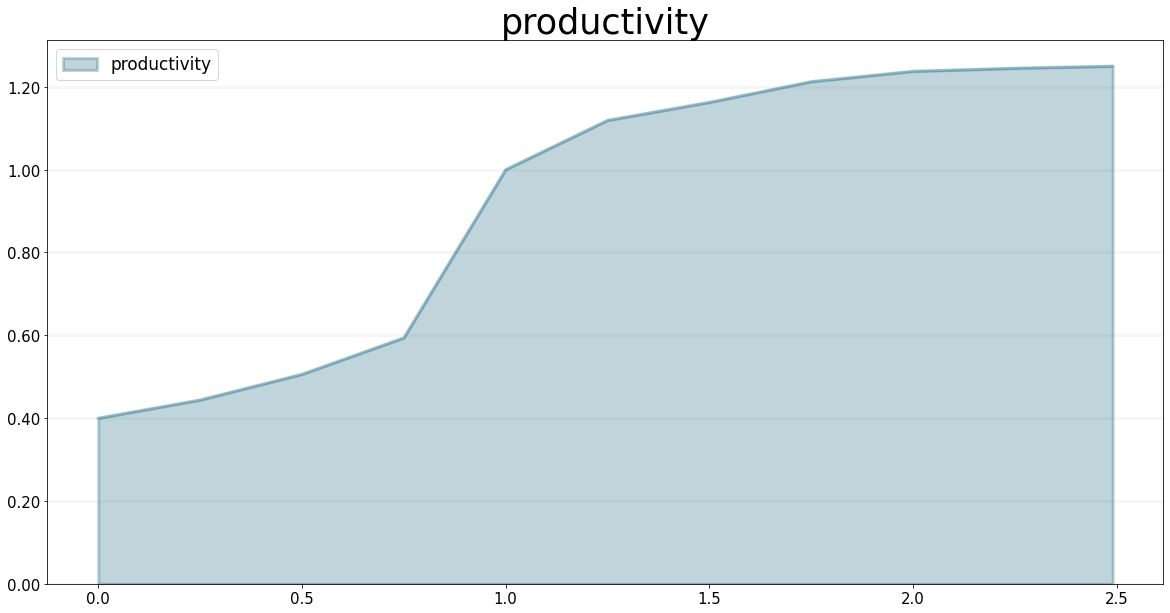

In [130]:
model.plot_lookup("productivity")

## Equations

### Equation for our ***Flow***

\begin{equation*}
Completion Rate  = p * \frac{s} {e}
\end{equation*}

**p** = average productivity of staff
**e** = effort per task,  
**s** = staff

Notes: As the staff grows, so does the completion rate. As the productivity increases so does the completion rate. As the effort per task grows, the completrion rate shrinks. ***sd.min() used to constrain the completion rate to never be larger than the number of open tasks.***

In [131]:
completionRate.equation = sd.max(0.0, sd.min(openTasks, productivity*(staff/effortPerTask)))

### Equations for our ***Converters***

In [132]:
currentTime.equation = sd.time()

In [133]:
remainingTime.equation = deadline - currentTime

In [134]:
productivity.equation = sd.lookup(schedulePressure, "productivity")

\begin{equation*}
Schedule Pressure   = \frac{remaining required effort} {remaining work capacity} = \frac{(t * e)} {(s * rt)}
\end{equation*}

**t** = open tasks, 
**e** = effort per task,  
**s** = staff, 
**rt** = remaining time 

Notes: Schedule pressure increases when there are more open tasks and higher effort per task. It shrinks when there is a larger staff and there is a larger remaining time. ***sd.max used to ensure division by 0 never occurs. sd.min used to cap the schedule pressure to a max of 2.5***

In [135]:
schedulePressure.equation = sd.min((openTasks * effortPerTask) / (staff * sd.max(remainingTime, 1)), 2.5)

### Equations for our ***Stocks*** 

In [136]:
openTasks.equation = -completionRate

In [137]:
closedTasks.equation = completionRate

## Registering Model 

In [138]:
bptk.register_model(model)

## Testing the Model 

In [139]:
closedTasks(50)

61.36053058042444

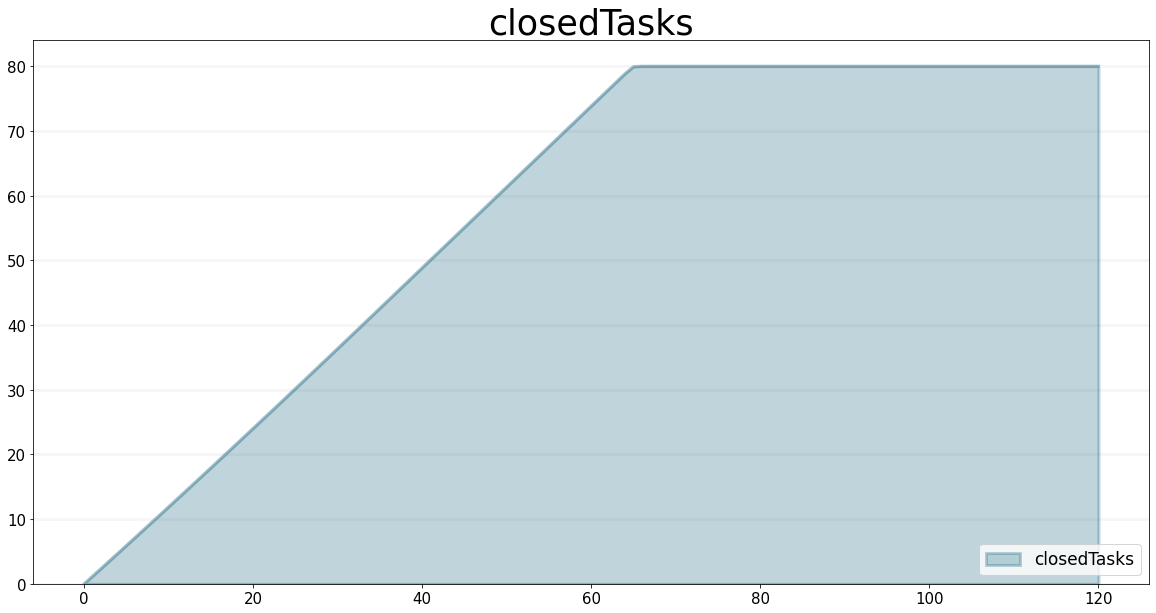

In [140]:
closedTasks.plot()

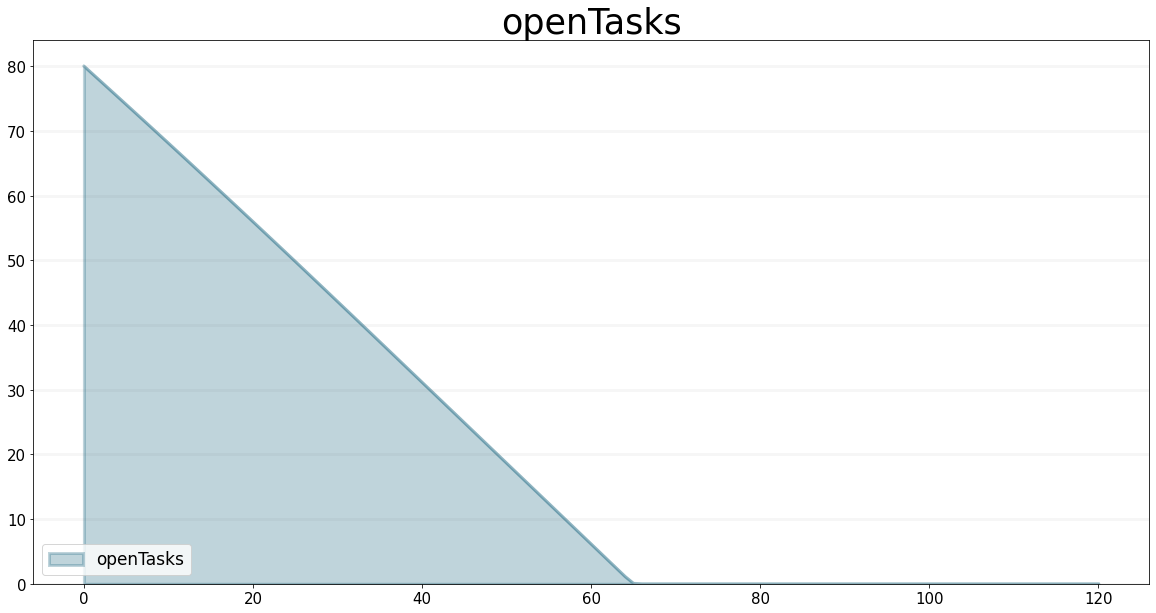

In [141]:
openTasks.plot()

## Generating Scenairos 

In [142]:
scenairo_manager = {
    "smSimpleProjectManagementDSL": {
        "model": model, 
        "base_constants": {
            "deadline": 100.0, 
            "initialStaff": 1.0, 
            "effortPerTask": 1.0, 
            "initialOpenTasks": 100.0, 
        }, 
        "base_points": {
            "productivity": [
                [0,0.4],
                [0.25,0.444],
                [0.5,0.506],
                [0.75,0.594],
                [1,1],
                [1.25,1.119],
                [1.5,1.1625],
                [1.75,1.2125],
                [2,1.2375],
                [2.25,1.245],
                [2.5,1.25]
            ]
        }
    }
}

In [143]:
bptk.register_scenario_manager(scenairo_manager)

### Varying Amount of Tasks - High Productivity w/ Schedule Pressure

In [144]:
bptk.register_scenarios(
    scenarios = {
        "scenario25": {
            "constants": {
                "initialOpenTasks": 25
            }
        }, 
        "scenario50": {
            "constants": {
                "initialOpenTasks": 50
            }
        }, 
         "scenario120": {
            "constants": {
                "initialOpenTasks": 120
            }
        }, 
        
    }, 
    scenario_manager="smSimpleProjectManagementDSL"
)

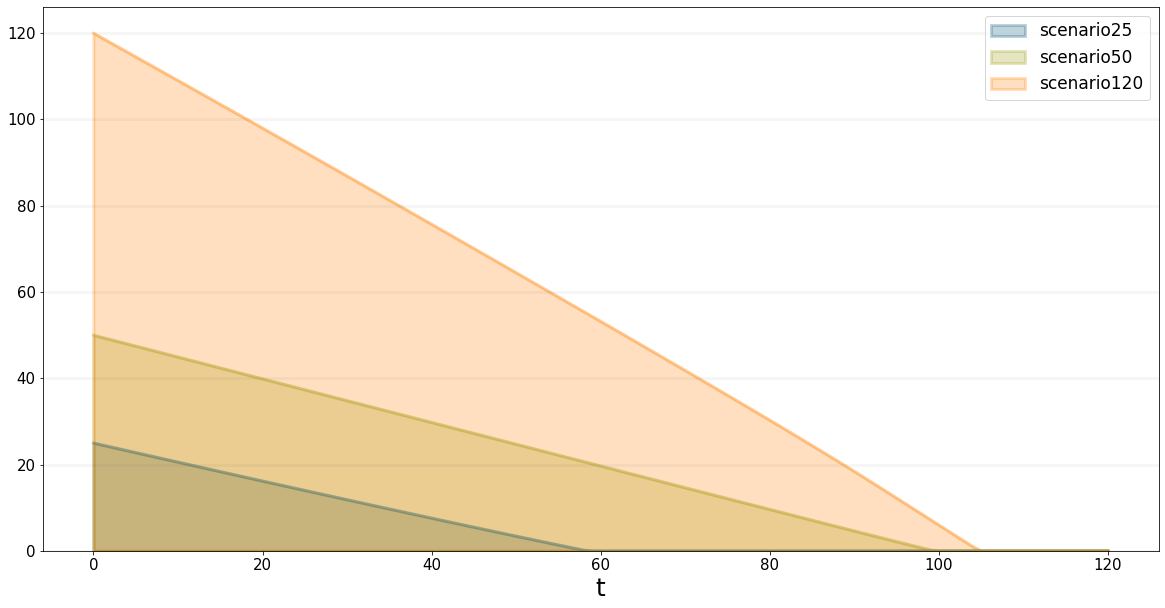

In [145]:
bptk.plot_scenarios(
    scenarios="scenario25,scenario50,scenario120", 
    scenario_managers="smSimpleProjectManagementDSL", 
    equations="openTasks", 
    series_names={
        "smSimpleProjectManagementDSL_scenario25_openTasks":"scenario25",
        "smSimpleProjectManagementDSL_scenario50_openTasks":"scenario50", 
        "smSimpleProjectManagementDSL_scenario120_openTasks":"scenario120",
    }
    
)

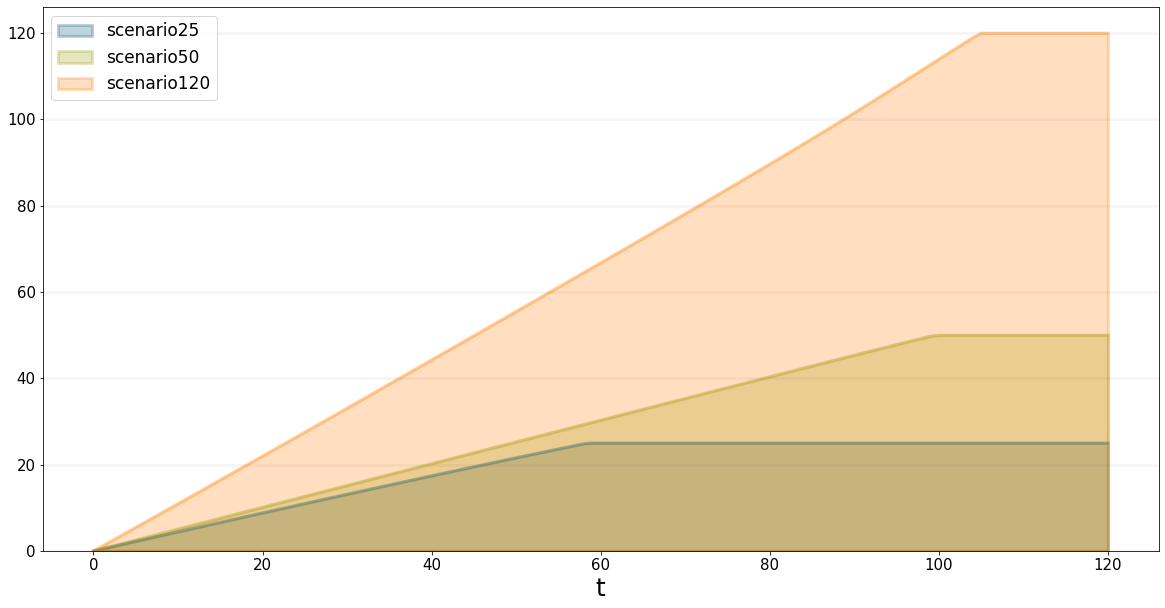

In [146]:
bptk.plot_scenarios(
    scenarios="scenario25,scenario50,scenario120", 
    scenario_managers="smSimpleProjectManagementDSL", 
    equations="closedTasks", 
    series_names={
        "smSimpleProjectManagementDSL_scenario25_closedTasks":"scenario25",
        "smSimpleProjectManagementDSL_scenario50_closedTasks":"scenario50", 
        "smSimpleProjectManagementDSL_scenario120_closedTasks":"scenario120",
    }
    
)

### Varying Amount of Tasks - Decreased Productivity w/ Schedule Pressure

In [147]:
scenairo_manager2 = {
    "lowProductivityPM": {
        "model": model, 
        "base_constants": {
            "deadline": 100.0, 
            "initialStaff": 1.0, 
            "effortPerTask": 1.0, 
            "initialOpenTasks": 100.0, 
        }, 
        "base_points": {
            "productivity": [
                [0,0.4],
                [0.25,0.444],
                [0.5,0.506],
                [0.75,0.594],
                [1,1],
                [1.25,0.99],
                [1.5,0.77],
                [1.75,0.55],
                [2,0.44],
                [2.25,0.4],
                [2.5,0.4]
            ]
        }
    }
}

In [148]:
bptk.register_scenario_manager(scenairo_manager2)

In [149]:
bptk.register_scenarios(
    scenarios = {
        "scenarioLow": {
            "constants": {
                "initialOpenTasks": 25
            },
        }, 
        "scenarioMedium": {
             "constants": {
                "initialOpenTasks": 50
            },   
        }, 
         "scenarioHigh": {
             "constants": {
                "initialOpenTasks": 125
            }, 
        }
        
    }, 
    scenario_manager="lowProductivityPM"
)

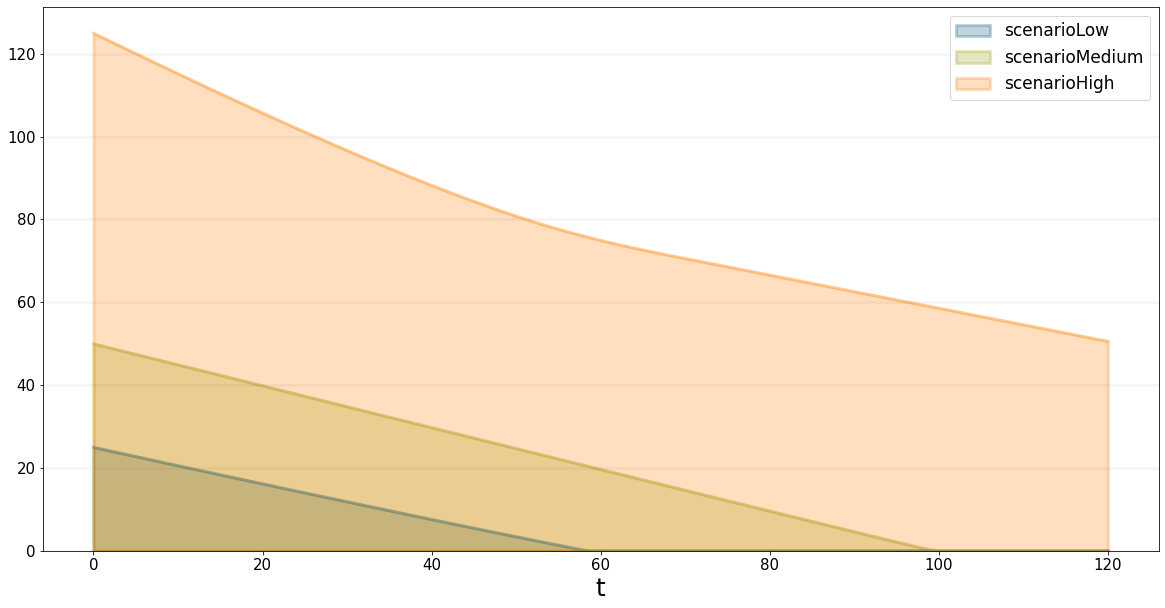

In [150]:
bptk.plot_scenarios(
    scenarios="scenarioLow,scenarioMedium,scenarioHigh", 
    scenario_managers="lowProductivityPM", 
    equations="openTasks", 
    series_names={
        "lowProductivityPM_scenarioLow_openTasks":"scenarioLow",
        "lowProductivityPM_scenarioMedium_openTasks":"scenarioMedium", 
        "lowProductivityPM_scenarioHigh_openTasks":"scenarioHigh",
    }
    
)

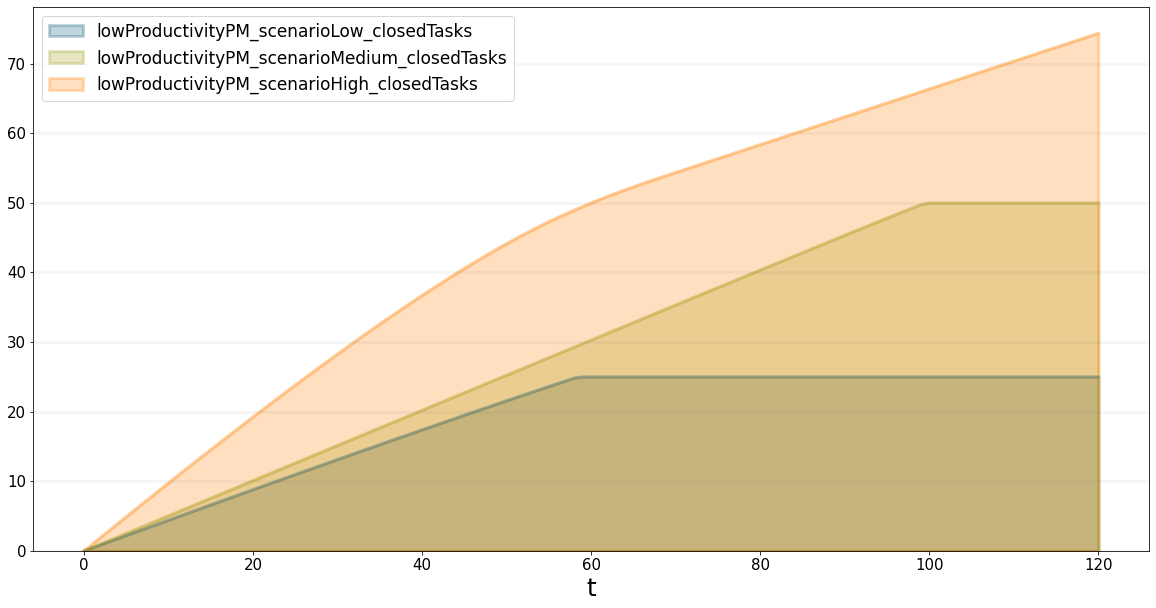

In [151]:
bptk.plot_scenarios(
    scenarios="scenarioLow,scenarioMedium,scenarioHigh", 
    scenario_managers="lowProductivityPM", 
    equations="closedTasks", 
    series_names={
        "smSimpleProjectManagementDSL_scenarioLow_closedTasks":"scenarioLow",
        "smSimpleProjectManagementDSL_scenarioMedium_closedTasks":"scenarioMedium", 
        "smSimpleProjectManagementDSL_scenarioHigh_closedTasks":"scenarioHigh",
    }
)

In [152]:
bptk.list_scenarios(scenario_managers=["smSimpleProjectManagementDSL"])


*** smSimpleProjectManagementDSL ***
	 scenario25
	 scenario50
	 scenario120


### Varying Amount of Tasks - Static Productivity w/ Schedule Pressure

In [153]:
scenairo_manager3 = {
    "medProductivityPM": {
        "model": model, 
        "base_constants": {
            "deadline": 100.0, 
            "initialStaff": 1.0, 
            "effortPerTask": 1.0, 
            "initialOpenTasks": 100.0, 
        }, 
        "base_points": {
            "productivity": [
                [0,0.4],
                [0.25,0.444],
                [0.5,0.506],
                [0.75,0.594],
                [1,1],
                [1.25,1],
                [1.5,1],
                [1.75,1],
                [2,1],
                [2.25,1],
                [2.5,1]
            ]
        }
    }
}

In [154]:
bptk.register_scenario_manager(scenairo_manager3)

In [155]:
bptk.register_scenarios(
    scenarios = {
        "scenarioLow": {
            "constants": {
                "initialOpenTasks": 25
            },
        }, 
        "scenarioMedium": {
             "constants": {
                "initialOpenTasks": 50
            },   
        }, 
         "scenarioHigh": {
             "constants": {
                "initialOpenTasks": 125
            }, 
        }
        
    }, 
    scenario_manager="medProductivityPM"
)

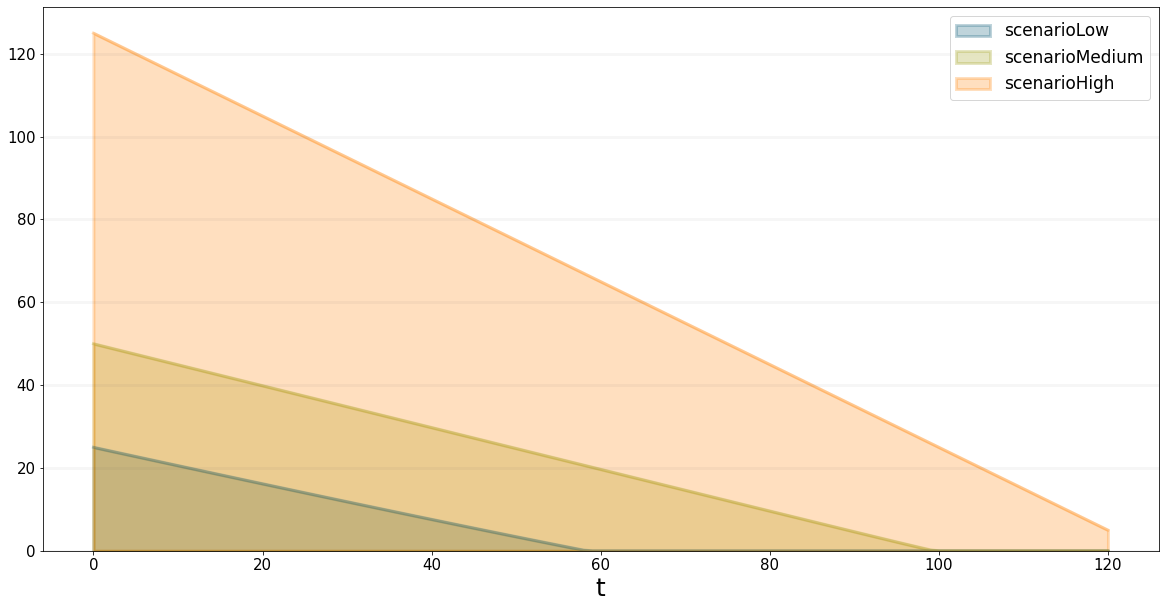

In [156]:
bptk.plot_scenarios(
    scenarios="scenarioLow,scenarioMedium,scenarioHigh", 
    scenario_managers="medProductivityPM", 
    equations="openTasks", 
    series_names={
        "medProductivityPM_scenarioLow_openTasks":"scenarioLow",
        "medProductivityPM_scenarioMedium_openTasks":"scenarioMedium", 
        "medProductivityPM_scenarioHigh_openTasks":"scenarioHigh",
    }
    
)

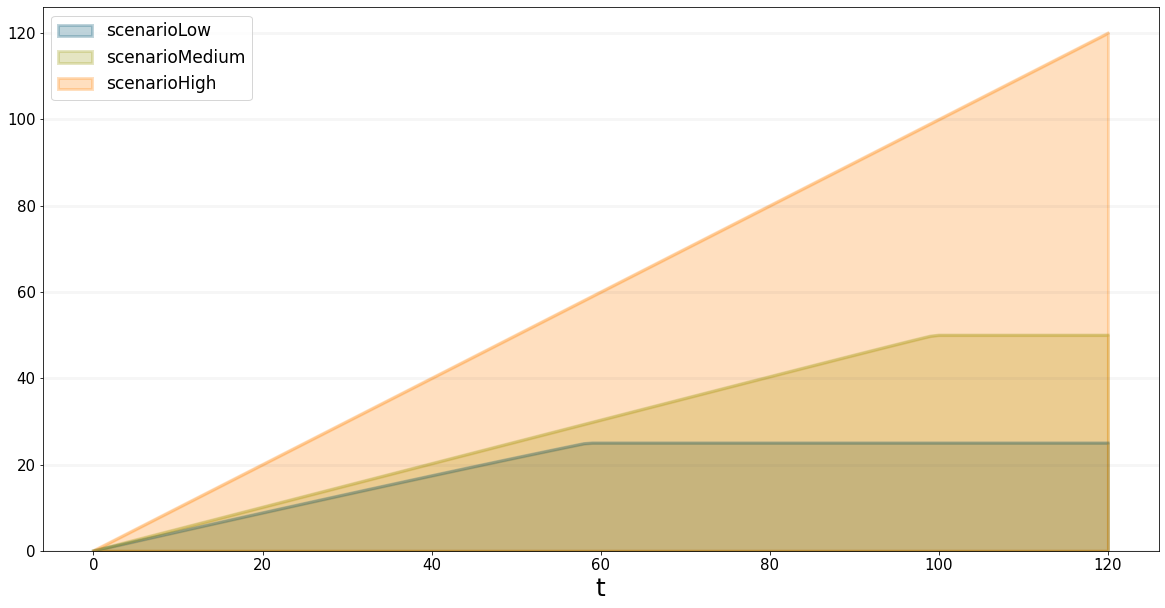

In [157]:
bptk.plot_scenarios(
    scenarios="scenarioLow,scenarioMedium,scenarioHigh", 
    scenario_managers="medProductivityPM", 
    equations="closedTasks", 
    series_names={
        "medProductivityPM_scenarioLow_closedTasks":"scenarioLow",
        "medProductivityPM_scenarioMedium_closedTasks":"scenarioMedium", 
        "medProductivityPM_scenarioHigh_closedTasks":"scenarioHigh",
    }
    
)

## Agent Based Modeling? 

Changing this model above to agent based. There are two kinds of agents: 
   1. **Staff Member**
       - Status: ***available*, *not_available***
       - can send events to **Task** agent: 
           - *task_started*
           - *in_progress*
   2. **Task** 
       - Status: ***open*, *in_progress*, *closed***
       - Effort: ***initial_effort*, *remaining_effort***
       - recieve Events from **Staff Member** Agent: 
         - *task_started* event: change status to *in_progress*
         - *in_progress* event: reduces *remaining_effort*
       - If *remaining_effort* = 0, mark as status as *closed*
       
Note: Tasks only respond to events. They never send them. 

#### Process: 
1. Staff Member checks status (am I *available* or not?)
    1. If Staff Member is available, it takes next Task and changes status to *not_available*. Staff Member sends *task_started* event to the Task
    2. If Staff Member is *not_available*, it continues working on the Task at hand. Staff Member sends *in_progress* event to the Task and records the amount of work done on the task.
3. Staff Member Checks its current task to see if it is completed. 
    1. If Task of Staff Member is completed, change state to *available*


#### Staff Member Agent Details

In [158]:
from BPTK_Py import Agent
from BPTK_Py import log

### Building Our Staff Member Agent 

In [159]:
class Staff(Agent): 
    
    #constructor 
    def initialize(self): 
        self.agent_type = "staffMember"
        self.state = "available"
        self.set_property("task", {"type": "Agent", "value": None})
        
    #impliments Process above 
    def act(self, time, round_no, step_no): 
        
        #max amount of work the staff member can do 
        work_capacity = self.model.dt * self.model.productivity
        
        while work_capacity > 0: 
            if self.state == "available":
                #pull the next task from the queue 
                self.task = self.model.next_agent("task", "open")
                #if there is a task, set to staff member to busy and send event to Task agent
                if self.task is not None:
                    self.state = "busy"
                    self.task.receive_instantaneous_event(
                        Event("taskStarted", self.id, self.task.id)
                    )
                else: 
                    #break the while loop 
                    work_capacity = 0
                    
            if self.state == "busy": 
                #calculating progress of task 
                work_done = min(work_capacity, self.task.remaining_effort)
                work_capacity -= work_done
                self.task.recieve_instantaneous_event(
                    Event("taskProgress", self.id, self.task.id, {"progress": work_done})
                )
                
                if self.task.state == "closed":
                    self.state = "available"
                    self.task = None
                
                

### Building our Task Agent 

In [160]:
class Task(Agent):
    
    def initialize(self): 
        self.agent_type = "task"
        self.state = "open"
        self.set_property("remaining_effort", {"type": "Double", "value": 0})
        
        self.register_event_handler(["open"], "task_started", self.handle_stated_event)
        self.register_event_handler(["in_progress"], "task_progress", self.handle_progress_event)
        
    def handle_started_event(self, event):
        self.remaining_effort = self.effort
        self.state = "in_progress"
        
    def handle_progress_event(self, event): 
        self.remaining_effort = max(self.remaining_effort-event.data["progress"], 0)
        
        if self.remaining_effort == 0:
            self.state = "closed"

### Building our Controller Agent - note looks like this is an abstraction from the docs online

In [161]:
from BPTK_Py import Agent

class Controlling(Agent):
    
    def initialize(self):
        self.agent_type = "controlling"
        self.state = "active"
        self.set_property("productivity", {"type": "Double", "value": 1})
        self.set_property("schedule_pressure", {"type": "Double", "value": 1})
        
    def act(self, time, round_no, step_no): 
        #this seems redundant if this already exists in the model class - need to review 
        self.productivity = self.model.productivity
        self.schedule_pressure = self.model.schedule_pressure 

### Building our Simple Project Management Model 

In [239]:
from BPTK_Py import Model
from BPTK_Py.widgets import WidgetLoader

class SPM(Model): 
    def instantiate_model(self):
        
        #registering our agents
        self.register_agent_factory("staffMember", lambda agent_id, model, properties: StaffMember(agent_id, model, properties))
        self.register_agent_factory("task", lambda agent_id, model, properties: Task(agent_id, model, properties))
        self.register_agent_factory("controlling", lambda agent_id, model, properties: Controlling(agent_id, model, properties))
        
        #adding attributes
        self._productivity=1
        self._schedule_pressure=1
        
    #defining productivity and schedule pressure at each time step 
    def begin_round(self, time, sim_round, step): 
        remaining_effort = 0
        task_ids = self.agent_ids("task")
        
        #looping through tasks to find open ones and sum their effort
        for task_id in task_ids:
            task = self.agent(task_id)
            if task.state == "open":
                remaining_effort += task.effort
        
        #looping through in-progress tasks and summing remaining effort 
        staff_ids = self.agent_ids("staff_member")
        for staff_id in staff_ids:
            #pulling task for specific staff member
            task_in_progress = self.agent(staff_id).task 
            if task_in_progress is not None:
                #summing remaining effort 
                remaining_effort += task_in_progress.remaining_effort
        
        #calculating some vars 
        remaining_time = self.deadline - self.scheduler.current_time
        num_staff_members = self.agent_count("staff_member")
        
        #calculating schedule pressure(schedule pressure eq. changes?)
        if remaining_time > 0:
            self._schedule_pressure = min(remaining_effort/(remaining_time * num_staff_members), 2.5)
        elif remaining_effort > 0:
            self._schedule_pressure = min(remaining_effort/(self.dt * num_staff_members), 2.5)
        else: 
            self._schedule_pressure = 1
        
        #productivity look up 
        productivity_lookup = self.get_property("productivity")
        self._productivity = self.lookup(
            self._schedule_pressure, 
            productivity_lookup["values"]
        )
        
    #getters 
    @property
    def productivity(self): 
        return self._productivity
    @property 
    def schedule_pressure(self):
        return self._schedule_pressure
    
    #Widget for visualization 
    def build_widget(self): 
        widget_loader = WidgetLoader()
        states = {1: "in_progress", 2: "closed"}
        agents = [agent for agent in self.agents if agent.agent_type =="task"]
        
        widget.loader.create_widget("AgentStatusWidget", state=states, agents=agents)
        
        return widget_loader
                
                
                
        

### Running the Model - Note Running into Bugs on this. Docs do not match implimentation. 

In [249]:
from BPTK_Py import bptk

In [250]:
bptk=bptk()

In [251]:
agent_model = SPM()

In [252]:
agentManager = {
  "agentSmp": {
    "type": "abm",
    "name": "Simple Project Management Model",
    "model": agent_model,
  }
}

In [253]:
bptk.register_scenario_manager(agentManager)

In [254]:
agentScens = {
      "scenario80": {
        "runspecs": {
          "starttime": 0,
          "stoptime": 120,
          "dt": 0.25
        },
        "properties": {
          "deadline":
         {
            "type": "Integer",
            "value": 100
          },
          "productivity":
          {
            "type": "Lookup",
            "value": [[0, 0.4], [0.25, 0.444], [0.5, 0.506], [0.75, 0.594], [1, 1], [1.25, 1.119], [1.5, 1.1625], [1.75, 1.2125], [2, 1.2375], [2.25, 1.245], [2.5, 1.25] ]
          }
        },
        "agents": [
          {
            "name": "staff_member",
            "count": 1
         },
          {
            "name": "controlling",
            "count": 1
          }
          ,
          {
            "name": "task",
            "count": 80,
            "properties":
            {
              "effort":
              {
                "type": "Double",
                "value": 1
              }
            }
          }
        ]
      }
    }

In [255]:
bptk.register_scenarios(agentScens, "agentSmp")

In [256]:
bptk.list_scenarios(scenario_managers=["agentSmp"])


*** agentSmp ***
	 scenario80


In [257]:
f=bptk.run_abm_with_widget(
    scenario_manager="agentSmp",
    scenario="scenario100",agents=["task"],
    agent_states=["open","closed"]
)

TypeError: instantiate_model() got an unexpected keyword argument 'reset'

In [258]:
Might switch to new package


SyntaxError: invalid syntax (<ipython-input-258-08acc8b81777>, line 1)

### New Goals: 
1. Review papers and topics on ABM for Project Management 
2. Potentially enroll in free course here: https://www.coursera.org/lecture/modeling-simulation-natural-processes/implementation-of-agent-based-models-196XP
    - Is this relevant? Is there a better process? SOW for Projectile? 
1. Build a Working ABM For Project Management Topic 
    - Consider Mesa package in Python 
    

In [ ]:
Ending the stream! Thanks! 